In [321]:
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

In [ ]:
class BaseAugmentor(object):
    """Base augmentator class.

    - Meant to be subclassed.
    - Method `augment` must be overridden in subclas.
    """
    def set_seed(self, random_seed) -> None:
        self.RS = np.random.RandomState(seed=random_seed)

    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """

        raise NotImplementedError(
            'you must override this method in the subclass.'
        )

    def set_random_state(self, random_seed: int) -> None:
        self.random_state = np.random.RandomState(seed=random_seed)

    @property
    def random_state(self) -> np.random.RandomState:
        if not hasattr(self, '_random_state'):
            raise AttributeError('attribute `random_state` is not set. Use `set_random_state`.')
        else:
            return self._random_state
    
    @random_state.setter 
    def random_state(self, random_state: np.random.RandomState) -> None:
        if not isinstance(random_state, np.random.RandomState):
            raise TypeError(
                f'`random_state` must be of type `np.random.RandomState`, is `{type(random_state).__name__}`.'
            )
        self._random_state = random_state


class FlipAugmentor(BaseAugmentor):
    """Random flip x and y dimensions."""
    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array using random horizontal and vertical flipping.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """

        flip_vertical = self.random_state.randint(0, 2)
        flip_horizontal = self.random_state.randint(0, 2)

        flip_axes = []
        if flip_vertical:
            flip_axes.append(0)

        if flip_horizontal:
            flip_axes.append(1)

        if len(flip_axes) > 0:
            cutout = np.flip(cutout, axis=flip_axes)

        return cutout

    def __repr__(self) -> str:
        return 'FlipAugmentor()'


class RotateAugmentor(BaseAugmentor):
    """Random rotate spatial dimensions."""
    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array using random rotation flipping.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """
        num_rotate = self.random_state.randint(0, 4)

        cutout = np.rot90(cutout, k=num_rotate, axes=(0, 1))

        return cutout

    def __repr__(self) -> str:
        return 'RotateAugmentor()'


class PixelNoiseAugmentor(BaseAugmentor):
    """Random noise at pixel level."""
    def __init__(self, scale: float) -> None:
        """Init PixelNoiseAugmentor.
        
        Args:
            scale: scale of noise.
        """
        self.scale = scale

    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array using pixel-level noise.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """
        random_noise = self.random_state.randn(*cutout.shape) * self.scale

        return cutout + random_noise

    def __repr__(self) -> str:
        return f'PixelNoiseAugmentor(scale={self.scale})'


class ChannelNoiseAugmentor(BaseAugmentor):
    """Random noise at channel level."""
    def __init__(self, scale: float) -> None:
        """Init ChannelNoiseAugmentor.
        
        Args:
            scale: scale of noise.
        """
        self.scale = scale

    def augment(self, cutout: np.ndarray) -> np.ndarray:
        """Augment a 3D array using channel-level noise.

        Augments:
            cutout: the input 3D array, shape (x, y, channels).

        Returns:
            Augmented array with same shape as cutout.
        
        """
        random_noise = self.random_state.randn(cutout.shape[2]) * self.scale

        return cutout + random_noise[np.newaxis, np.newaxis, ...]

    def __repr__(self) -> str:
        return f'ChannelNoiseAugmentor(scale={self.scale})'


class AugmentorChain(object):
    def __init__(self, random_seed: int, augmentors: list[BaseAugmentor] | None) -> None:
        self.random_seed = random_seed
        self.augmentors = augmentors

        if self.augmentors is not None:
            for augmentor in self.augmentors:
                augmentor.set_random_state(random_seed)

    def augment(self, cutout: np.ndarray) -> np.ndarray:

        if self.augmentors is None:
            return cutout

        for augmentor in self.augmentors:
            cutout = augmentor.augment(cutout)

        return cutout

    def __repr__(self) -> str:
        if self.augmentors is None:
            return f'AugmentorChain(augmentors=None)'

        autmentors_repr = [str(augmentor) for augmentor in self.augmentors]
        return f'AugmentorChain(random_seed={self.random_seed}, augmentors=[{", ".join(autmentors_repr)}])'


In [ ]:


# flip_augmentor.set_random_state(0)
# rotate_augmentor.set_random_state(0)
# pixel_augmentor.set_random_state(0)
# channel_augmentor.set_random_state(0)

In [371]:
class RSData(Dataset):
    def __init__(
            self,
            ds_path: str,
            mask_area: list[int] | int,
            cutout_size: int = 21,
            rs_means: xr.DataArray | None = None,
            rs_stds: xr.DataArray | None = None,
            augmentor_chain: AugmentorChain | None = None):

        super().__init__()

        # TODO: limit cutout

        self.ds = xr.open_zarr(ds_path)

        if cutout_size % 2 == 0:
            raise ValueError('`cutout_size` must be an odd integer.')

        self.mask_values = self.get_mask_values(mask_area)

        self.cutout_size = cutout_size

        self.mask = self.ds.mask.isin(self.mask_values).compute()

        self.coords = np.argwhere(self.mask.values)

        if (rs_means is None) != (rs_stds is None):
            raise ValueError(
                'either pass both of `rs_means` and `rs_stds` or none.'    
            )

        if rs_means is None:
            rs_means = self.ds.rs.where(self.mask).mean(('x', 'y')).compute()
            rs_stds = self.ds.rs.where(self.mask).std(('x', 'y')).compute()

        self.rs_means = rs_means
        self.rs_stds = rs_stds

        if augmentor_chain is None:
            self.augmentor_chain = AugmentorChain(random_seed=0, augmentors=[])
        else:
            self.augmentor_chain = augmentor_chain

    def get_mask_values(self, mask_area: list[int] | int) -> np.ndarray:
        mask_area_ = np.array([mask_area] if isinstance(mask_area, int) else mask_area)

        if any(mask_area_ < 0) or any(mask_area_ > 4):
            raise ValueError('`mask_values` must be in range [0, ..., 4]')

        mask_values = np.argwhere(np.isin((np.arange(1, 13) - 1) % 4, mask_area_ - 1)).flatten() + 1

        if any(mask_area_ == 0):
            mask_values = np.concatenate((mask_values, np.zeros(1, dtype=int)))

        return mask_values

    def __len__(self) -> int:
        return len(self.coords)

    def __getitem__(self, index: int):
        x_i, y_i = self.coords[index]

        offset = int(self.cutout_size // 2)

        cutout = self.ds.rs.isel(
            x=slice(x_i - offset, x_i + offset + 1),
            y=slice(y_i - offset, y_i + offset + 1),
        )

        # Standardize.
        cutout = (cutout - self.rs_means) / self.rs_stds

        # Transpose, make sure x and y are first dimensions.
        cutout = cutout.transpose('x', 'y', ...).values

        # Augment.
        cutout = self.augmentor_chain.augment(cutout)

        # Put channel on first dimension, from (x, y, c) to (c, x, y).
        cutout = cutout.transpose(2, 0, 1)

        label_sel = self.ds.label.isel(
            x=x_i,
            y=y_i,
        ).values

        return cutout.astype('float32'), label_sel.astype('int')


In [ ]:
ac = AugmentorChain(
    random_seed=1,
    augmentors=[
        FlipAugmentor(),
        RotateAugmentor(),
        PixelNoiseAugmentor(scale=0.1),
        ChannelNoiseAugmentor(scale=0.1)
    ]
)

rsdata_train = RSData(
    '../data/combined.zarr',
    mask_area=[1, 4],
    cutout_size=21,
    augmentor_chain=ac
)

rsdata_valid = RSData(
    '../data/combined.zarr',
    mask_area=[2],
    cutout_size=21,
    augmentor_chain=ac,
    rs_means=rsdata_train.rs_means,
    rs_stds=rsdata_train.rs_stds
)

In [373]:
train_dl = DataLoader(rsdata_train, batch_size=10, shuffle=True)

In [374]:
batch = next(iter(train_dl))

In [375]:
batch[0].shape

torch.Size([10, 4, 21, 21])

In [320]:
rs, label = rsdata[0]

In [325]:
rsdata.ds.rs.max().compute()

<xarray.DataArray 'rs' ()> Size: 2B
array(65535, dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0

In [328]:
rs.shape

(21, 21, 4)

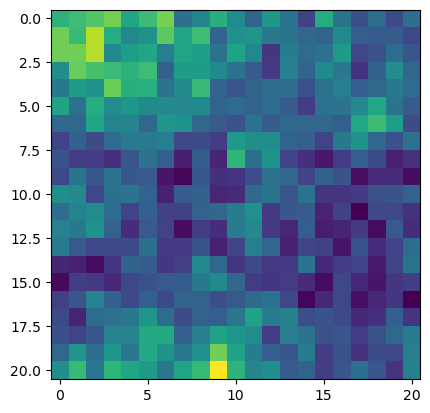

In [334]:
plt.imshow(rs[..., 3])

In [263]:
c.transpose('x', 'y', ...).values

array([[[2056,  671,  832,  814],
        [1955,  739,  838,  830],
        [2326,  679,  983,  846],
        ...,
        [2391,  483,  792,  706],
        [2408,  369,  749,  657],
        [2381,  463,  736,  707]],

       [[1784,  744,  839,  864],
        [1824,  782,  824,  825],
        [2088,  746,  956,  905],
        ...,
        [2373,  502,  805,  682],
        [2403,  398,  857,  681],
        [2392,  454,  745,  653]],

       [[1839,  691,  838,  865],
        [1946,  684,  864,  865],
        [2241,  746, 1036,  904],
        ...,
        [2546,  476,  817,  666],
        [2329,  407,  794,  708],
        [2281,  496,  838,  672]],

       ...,

       [[2258,  376,  827,  665],
        [2064,  381,  789,  650],
        [1959,  298,  762,  676],
        ...,
        [2569,  516,  844,  666],
        [2591,  527,  863,  698],
        [2430,  502,  732,  725]],

       [[2677,  462,  887,  699],
        [2539,  590,  937,  767],
        [2099,  499,  699,  711],
        .

In [246]:
rsdata[0]

ValueError: Dimensions {'y', 'x'} do not exist. Expected one or more of ()

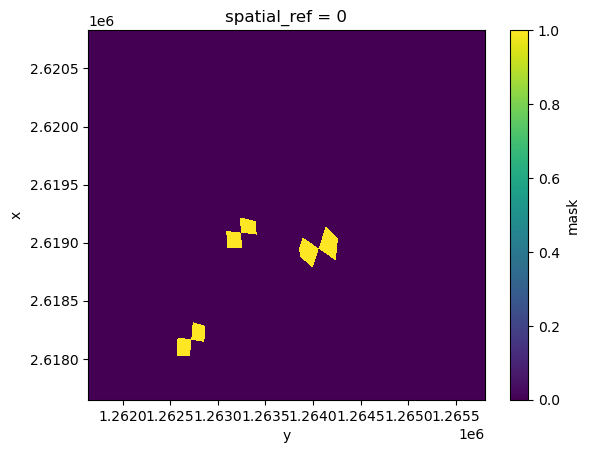

In [172]:
coarsen(rsdata.mask, reduction='max').plot()

In [370]:
x.transpose(2, 0, 1)

array([[[0, 1],
        [2, 3]]])